In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import jj
from scipy.signal import argrelextrema

### Spiking Neural Network Method

Josephson Junctions modeled to make firing neurons would imply that they should be used in a specific type of neural network called a Spiking Neural Network. The main inclusion of this type of network is time into the operation. Another difference being the nonlinear and nondifferentiable behavior. Also now the connections between the neurons, the synapses, are weighted for passing current onto the connected neurons. The neuron has a particular threshold at which it will begin firing at different speeds. The weight being how many outputs fire divided by the number of inputs firing.
My goals is to recreate the simple neural network with the same structure but with the Spiking Neural Network in mind.

In [2]:
def sigmoid(x):
    """
    Defines the sigmoid function
    """
    return 1.0/(1+ np.exp(-x))

def sigmoid_derivative(x):
    """
    Defines the derivative of the sigmoid function
    """
    return x * (1.0 - x)

def iin(i,t0,tf,tn):
    if tn < t0:
        return 0
    elif tn > tf:
        return 0
    else:
        return i

class NeuralNetwork:
    def __init__(self, x, y):
        self.input      = x
        self.weights1   = np.random.rand(self.input.shape[1],4) 
        self.weights2   = np.random.rand(4,1)                 
        self.y          = y
        self.output     = np.zeros(self.y.shape)

    def feedforward(self):
        # input the feed forward by multiplying first weights by their inputs and then the second weights with the output of the first layer
        self.layer1 = sigmoid(np.dot(self.input, self.weights1))
        self.output = sigmoid(np.dot(self.layer1, self.weights2))

    def backprop(self):
        # application of the chain rule to find derivative of the loss function with respect to weights2 and weights1
        d_weights2 = np.dot(self.layer1.T, (2*(self.y - self.output) * sigmoid_derivative(self.output)))
        d_weights1 = np.dot(self.input.T,  (np.dot(2*(self.y - self.output) * sigmoid_derivative(self.output), self.weights2.T) * sigmoid_derivative(self.layer1)))

        # update the weights with the derivative (slope) of the loss function
        self.weights1 += d_weights1
        self.weights2 += d_weights2

In [3]:
## Time domain set up
time = 300 # Final Time
n = 20000 # Resolution
dt = time / n # A single time step length
tspan = np.arange(0, time, dt)  # time span
ispan = np.zeros_like(tspan)

## First Neuron
phi_c = np.zeros_like(tspan)
v_c = np.zeros_like(tspan)

phi_p = np.zeros_like(tspan)
v_p = np.zeros_like(tspan)

## Second Neuron
phi_2c = np.zeros_like(tspan)
v_2c = np.zeros_like(tspan)

phi_2p = np.zeros_like(tspan)
v_2p = np.zeros_like(tspan)


## System Parameters
lmda = 0.1
gamma = 2.0
lmda_s = 0.5
lmda_p = 0.5
eta = 1
i_in = 0.3
i_b = 2.0

## Synapse parameters
Q = 0.05
lmda_syn = 0.3
r12 = 1.4
t0 = 30
omega = 1.0

## Initial Conditions, Nueron 1
phi_p[0] = 0
v_p[0] = 0
phi_c[0] = 0
v_c[0] = 0
i_p = -lmda*(phi_c[0] + phi_p[0]) + lmda_s*iin(i_in,t0,130,0) + (1-lmda_p)*i_b
i_c = (-lmda*(phi_c[0] + phi_p[0]) + lmda_s*iin(i_in,t0,130,0) - lmda_p*i_b)/eta

i_o = 0
id_o = 0
v_o = 0
vd_o = 0

## Initial Conditions, Neuron 2
phi_2p[0] = 0
v_2p[0] = 0
phi_2c[0] = 0
v_2c[0] = 0
i_2p = -lmda*(phi_2c[0] + phi_2p[0]) + lmda_s*i_o + (1-lmda_p)*i_b
i_2c = (-lmda*(phi_2c[0] + phi_2p[0]) + lmda_s*i_o - lmda_p*i_b)/eta


for j in range(np.size(tspan)):
    ispan[j] = iin(i_in,t0,130,tspan[j])


## Flux of First Neuron
for j in range(np.size(tspan)-1):
    phi_p[j+1], v_p[j+1] = jj.junction_step(phi_p[j], v_p[j], dt, gamma, i_p)
    phi_c[j+1], v_c[j+1] = jj.junction_step(phi_c[j], v_c[j], dt, gamma, i_c)
    i_p = -lmda*(phi_c[j+1] + phi_p[j+1]) + lmda_s*ispan[j+1] + (1-lmda_p)*i_b
    i_c = (-lmda*(phi_c[j+1] + phi_p[j+1]) + lmda_s*ispan[j+1] - lmda_p*i_b)/eta
    
    [i_o, id_o, v_o, vd_o] = jj.synapse_step(v_o, vd_o, i_o, id_o, v_p[j], v_2c[j], v_2p[j], gamma, omega, Q, lmda, lmda_syn, r12, dt)
    
    phi_2p[j+1], v_2p[j+1] = jj.junction_step(phi_2p[j], v_2p[j], dt, gamma, i_2p)
    phi_2c[j+1], v_2c[j+1] = jj.junction_step(phi_2c[j], v_2c[j], dt, gamma, i_2c)
    i_2p = -lmda*(phi_2c[j+1] + phi_2p[j+1]) + lmda_s*i_o + (1-lmda_p)*i_b
    i_2c = (-lmda*(phi_2c[j+1] + phi_2p[j+1]) + lmda_s*i_o - lmda_p*i_b)/eta    
    
flux = lmda*(phi_p+phi_c)
flux2 = lmda*(phi_2p + phi_2c)
maxima = argrelextrema(flux,np.greater)
spikes = maxima[0].size

1.0


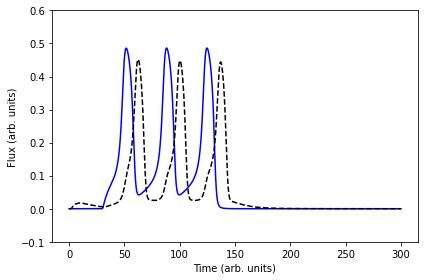

In [4]:
## Plotting
fig, ax1 = plt.subplots()

color = 'black'
fig.patch.set_facecolor('white')
ax1.set_xlabel('Time (arb. units)')
ax1.set_ylabel('Flux (arb. units)')
ax1.plot(tspan,flux, 'b')
ax1.plot(tspan,flux2,'k--')
# ax1.set_xlim(50,250)
ax1.set_ylim(-0.1,0.6)

fig.tight_layout()
plt.show()

### Fitting the Sigmoid Function Method
It is possible to fit the phase relation of the Josephson Junction to the sigmoid function used for the simple neural network to create a direct analogy with the artificial neural network. This can be done by adding a linear term near $\varphi \approx sin(\varphi)$ in the regime of $\phi_{in} \approx 0$. This would allow a direct replacement of the sigmoid function in the basic model I created, which show the ability of the junction to be uses as a neural network.

Note, time depending I may only be able to realize one of these methods, but would act as further potential work to be done.